In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import joblib

In [9]:
# Load the dataset
data = pd.read_csv('c:/Users/USER/Documents/Data Science Journy/StackingOptimization/driving_data.csv')

# Assume target variable is in between, adjust accordingly
target_column = 'Class'  # Replace with the actual target column name
X = data.drop(columns=[target_column])  # Features
y = data[target_column]   # Target (Driver ID)

# Encode categorical features in X
for column in X.select_dtypes(include=['object']).columns:
	X[column] = LabelEncoder().fit_transform(X[column])

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Check for feature correlation with target
correlation_matrix = data.apply(lambda x: pd.factorize(x)[0]).corr()
print(correlation_matrix[target_column].sort_values(ascending=False))

# Remove highly correlated features (Threshold: 0.9)
high_correlation_features = correlation_matrix[target_column][correlation_matrix[target_column].abs() > 0.9].index.tolist()
high_correlation_features.remove(target_column)  # Remove target from the list
X = X.drop(columns=high_correlation_features)


Class                                           1.000000
Long_Term_Fuel_Trim_Bank1                       0.379116
Engine_soacking_time                            0.186852
Engine_coolant_temperature.1                    0.144845
Torque_converter_turbine_speed_-_Unfiltered     0.114873
Torque_of_friction                              0.110172
Torque_converter_speed                          0.106669
Time(s)                                         0.097871
Engine_coolant_temperature                      0.075061
Accelerator_Pedal_value                         0.055409
Current_spark_timing                            0.048011
Engine_speed                                    0.035787
Flywheel_torque_(after_torque_interventions)    0.027184
Flywheel_torque                                 0.021356
Maximum_indicated_engine_torque                 0.018246
Activation_of_Air_compressor                    0.015651
Engine_Idel_Target_Speed                        0.015181
Steering_wheel_angle           

Cross-Validation Accuracy: 0.5461 ± 0.0979
Selected Features: [False  True False False  True False False  True False False False  True
 False False  True False False False False False False False  True False
 False False False False False False False  True False False  True False
 False False False False False False False False False False False False
 False False False  True  True]
Selected Feature Names: ['Accelerator_Pedal_value', 'Intake_air_pressure', 'Engine_soacking_time', 'Long_Term_Fuel_Trim_Bank1', 'Torque_of_friction', 'Maximum_indicated_engine_torque', 'Activation_of_Air_compressor', 'Engine_coolant_temperature.1', 'Time(s)', 'PathOrder']
Accuracy after RFE: 92.94%
Precision: 0.9340
Recall: 0.9294
F1 Score: 0.9294
Training Accuracy: 0.9298
Test Accuracy: 0.9294


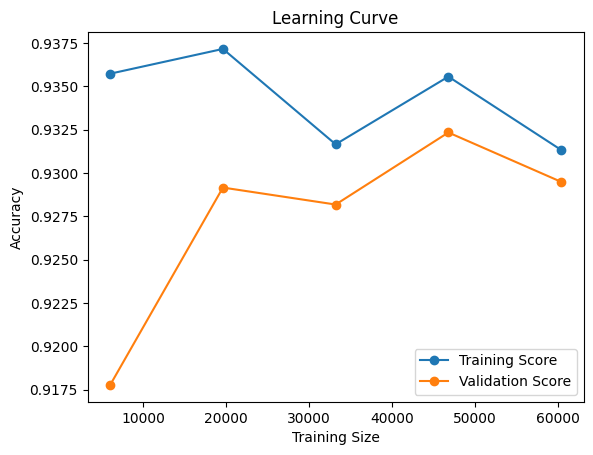

['driver_identification_model_rfe_rf.pkl']

In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature Selection using Recursive Feature Elimination (RFE) within Cross-Validation
base_model_for_rfe = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
n_features_to_select = 10  # Adjust based on dataset
rfe = RFE(estimator=base_model_for_rfe, n_features_to_select=n_features_to_select)

pipeline = Pipeline(steps=[('feature_selection', rfe), ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))])

# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Fit RFE on the training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Get the selected feature indices
selected_features = rfe.support_
print("Selected Features:", selected_features)

# Print the names of the selected features (if feature names are available)
feature_names = X.columns  # Use correct feature names
selected_feature_names = feature_names[selected_features]
print("Selected Feature Names:", selected_feature_names.tolist())

# Define Random Forest classifier with reduced complexity
random_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

# Train the Random Forest classifier on the selected features
random_classifier.fit(X_train_rfe, y_train)

# Make predictions on the test set
y_pred = random_classifier.predict(X_test_rfe)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy after RFE: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Check training vs. test accuracy
train_accuracy = accuracy_score(y_train, random_classifier.predict(X_train_rfe))
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot Learning Curve
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='accuracy')
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Validation Score')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

plot_learning_curve(random_classifier, X_train_rfe, y_train)

# Save the model
joblib.dump(random_classifier, 'driver_identification_model_rfe_rf.pkl')
